## 4.3 期待収益率と収益率の分散共分散行列が未知の場合

### 多変量正規分布からの資産収益率データの生成

コード 4.3 pyfin_asset_return_simulation.py

In [1]:
# -*- coding: utf-8 -*-
#%% NumPyの読み込み
import numpy as np
#   SciPyのstatsモジュールの読み込み
import scipy.stats as st
#   Pandasの読み込み
import pandas as pd
#%% 多変量正規分布からの乱数生成と保存
Mu = np.array([1.0, 3.0, 1.5, 6.0, 4.5])
Stdev = np.array([5.0, 10.0, 7.5, 15.0, 11.0])
CorrMatrix = np.array([[1.00, 0.25, 0.18, 0.10, 0.25],
                       [0.25, 1.00, 0.36, 0.20, 0.20],
                       [0.18, 0.36, 1.00, 0.25, 0.36],
                       [0.10, 0.20, 0.25, 1.00, 0.45],
                       [0.25, 0.20, 0.36, 0.45, 1.00]])
Sigma = np.diag(Stdev).dot(CorrMatrix).dot(np.diag(Stdev))
np.random.seed(9999)
T = 120
End_of_Month = pd.date_range('1/1/2007', periods=T, freq='M')
Asset_Names = [u'資産1', u'資産2', u'資産3', u'資産4', u'資産5']
Asset_Return = pd.DataFrame(st.multivariate_normal(Mu, Sigma).rvs(T),
                            index=End_of_Month, columns=Asset_Names)
Asset_Return.to_csv('asset_return_data.csv')

### 期待収益率と収益率の分散共分散行列をデータから推定する最適化

コード 4.4 pyfin_mvf_example3.py

pyfin_mvf_example3_ver1_1.py

/Users/masahiro/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


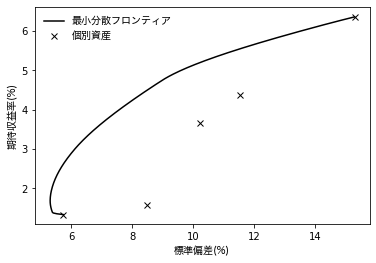

In [3]:
# -*- coding: utf-8 -*-
#%% NumPyの読み込み
import numpy as np
#   CVXPYの読み込み
import cvxpy as cvx
#   Pandasの読み込み
import pandas as pd
#   MatplotlibのPyplotモジュールの読み込み
import matplotlib.pyplot as plt
#   日本語フォントの設定
from matplotlib.font_manager import FontProperties
import sys
if sys.platform.startswith('win'):
    FontPath = 'C:\\Windows\\Fonts\\meiryo.ttc'
elif sys.platform.startswith('darwin'):
    FontPath = '/System/Library/Fonts/ヒラギノ角ゴシック W4.ttc'
elif sys.platform.startswith('linux'):
    FontPath = '/usr/share/fonts/truetype/takao-gothic/TakaoPGothic.ttf'
jpfont = FontProperties(fname=FontPath)
#%% 収益率データの読み込み
R = pd.read_csv('asset_return_data.csv', index_col=0)
T = R.shape[0]
N = R.shape[1]
Mu = R.mean().values
Sigma = R.cov().values * ((T - 1.0) / T)
Return_Dev = (R - Mu).values / np.sqrt(T)
#%% 空売り制約の下での分散最小化問題の設定
Weight = cvx.Variable(N)
Deviation = cvx.Variable(T)
Target_Return = cvx.Parameter(nonneg=True)
Risk_Variance = cvx.sum_squares(Deviation)
Opt_Portfolio = cvx.Problem(cvx.Minimize(Risk_Variance),
                            [Return_Dev @ Weight == Deviation,
                             Weight.T @ Mu == Target_Return,
                             cvx.sum(Weight) == 1.0,
                             Weight >= 0.0])
#%% 空売り制約の下での最小分散フロンティアの計算
V_Target = np.linspace(Mu.min(), Mu.max(), num=250)
V_Risk = np.zeros(V_Target.shape)
for idx, Target_Return.value in enumerate(V_Target):
    Opt_Portfolio.solve(solver=cvx.ECOS)
    V_Risk[idx] = np.sqrt(Risk_Variance.value)
#%% 最小分散フロンティアのグラフの作成
fig1 = plt.figure(1, facecolor='w')
plt.plot(V_Risk, V_Target, 'k-')
plt.plot(np.sqrt(np.diagonal(Sigma)), Mu, 'kx')
plt.legend([u'最小分散フロンティア', u'個別資産'],
           loc='best', frameon=False, prop=jpfont)
plt.xlabel(u'標準偏差(%)', fontproperties=jpfont)
plt.ylabel(u'期待収益率(%)', fontproperties=jpfont)
plt.show()